In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import DataLoader
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
#from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px

from teenmag_dataset import TeenmagData
from faces_dataset import FacesData

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)

cuda
11.3


# Encoder Decoder

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, hidden_dims, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, hidden_dims)
        #self.linear1 = nn.Linear(7*7*32, hidden_dims)

        self.linear2 = nn.Linear(hidden_dims, latent_dims)
        self.linear3 = nn.Linear(hidden_dims, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print("conv3:", x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        #rint(x.shape)
        #nput()
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z  

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, input_dims, hidden_dims, latent_dims, h, w):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.ReLU(True),
            nn.Linear(hidden_dims, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        #print("Decoder input:", x.shape)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims, h, w):
        super(VariationalAutoencoder, self).__init__()
        #self.encoder = VariationalEncoder(input_dims, hidden_dims, latent_dims,h ,w)
        #self.decoder = Decoder(input_dims, hidden_dims, latent_dims, h, w)
        self.encoder = VariationalEncoder(hidden_dims, latent_dims)
        self.decoder = Decoder(input_dims, hidden_dims, latent_dims, h, w)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Train lopp

In [7]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in tqdm(data, total=len(data)):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

# Datasets

In [8]:
batch_size = 256
data = torch.utils.data.DataLoader(
        #torchvision.datasets.MNIST('./data', 
        torchvision.datasets.FashionMNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=batch_size,
        shuffle=True)
sample = next(iter(data))[0]

# Hparams
latent_dims = 2
hidden_dims = 2048
epochs = 2000
h, w = 28, 28
input_dims = h*w
print(h,w)

28 28


In [ ]:
batch_size = 16
ds = FacesData()
ds.process(size=(28,28))
import torchvision.transforms as T
transform=T.Compose([T.ToTensor(), T.Resize(28)])
data = torch.utils.data.DataLoader(
        #TeenmagData(transform=torchvision.transforms.ToTensor()),
        ds,
        batch_size=batch_size,
        shuffle=True)
sample = next(iter(data))[0]

# Hparams
h, w = ds.h, ds.w
input_dims = ds.h*ds.w
latent_dims = 2
hidden_dims = 128
epochs = 100
print(h,w)

Loading 1500/4590 files.
 Images before cleaning: 1500.


In [30]:
print(sample.shape)
print(sample.shape[2]**2)
28*28
np.sqrt(1568)

torch.Size([16, 1, 28, 28])
784


39.59797974644666

## Visualize

Feature batch shape: torch.Size([16, 1, 28, 28])
Labels batch shape: torch.Size([16])


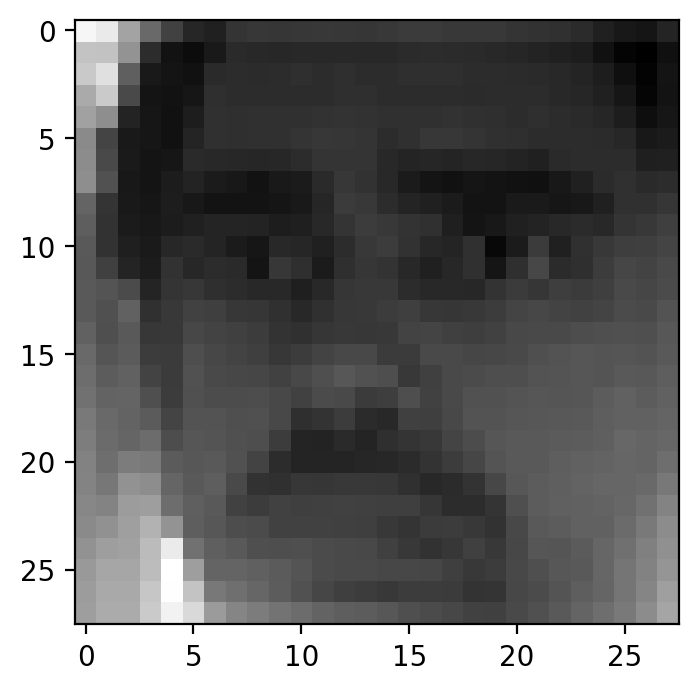

Label: 0


In [34]:
# Display image and label.
train_features, train_labels = next(iter(data))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:, :]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
encoded_samples = []
for sample in tqdm(ds):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/28 [00:00<?, ?it/s]

In [17]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/home/nicklas/Projects/vae/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nicklas/Projects/vae/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Train

In [36]:
print(f"(Training on {device}.")
vae = VariationalAutoencoder(input_dims, hidden_dims, latent_dims, h, w).to(device) # GPU
vae = train(vae, data, epochs)

(Training on cuda.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [19]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w_ = w
    img = np.zeros((n*h, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(h, w).to('cpu').detach().numpy()
            #print(x_hat.shape)
            img[(n-1-i)*w_:(n-1-i+1)*w_, j*w_:(j+1)*w_] = x_hat

    plt.imshow(img, extent=[*r0, *r1], cmap='gray')

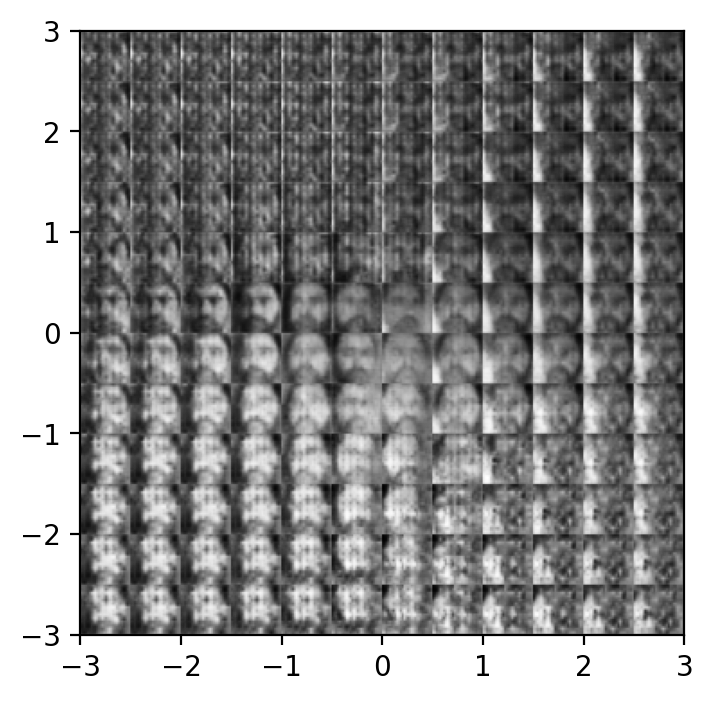

In [37]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

# Extra Fun

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [63]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(h, w)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [90]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 0][1].to(device) # find a 1
x_2 = x[y == 0][-1].to(device) # find a 0

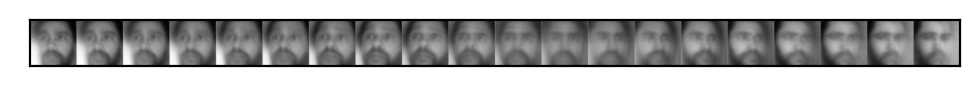

In [91]:
interpolate(vae, x_1, x_2, n=20)

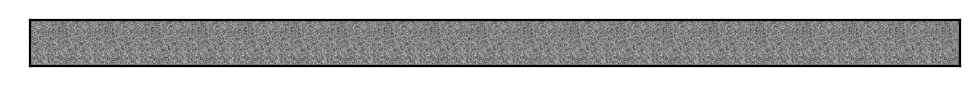

In [92]:
interpolate(autoencoder, x_1, x_2, n=20)

I also wanted to write some code to generate a GIF of the transition, instead of just a row of images. The code below modifies the code above to produce a GIF.

In [57]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=10):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)
    
    return images_list

In [58]:
imgs = interpolate_gif(vae, "vae", x_1, x_2)
img = Image.open('vae.gif').convert('RGB')
plt.imshow(img)
plt.show()

ValueError: cannot reshape array of size 4096 into shape (28,28)

<img src="vae.gif">

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)